# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [13]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

File already exists at ../data/raw/outliers_homework.csv. Skipping CSV creation to avoid overwrite.


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [14]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

## Load Data (provided or synthetic fallback)

In [15]:
data_path = Path('data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.000000,1.331519
1,0.050251,-1.115001
2,0.100503,1.969787
3,0.150754,2.706032
4,0.201005,2.686840


## TODO: Implement Outlier Functions (required)

In [16]:

import pandas as pd
import numpy as np

def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """
    Return boolean mask for IQR-based outliers.
    """
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - k * iqr, q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """
    Return boolean mask for Z-score outliers.
    """
    mu, sigma = series.mean(), series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    """
    Winsorize a series by clipping at lower/upper quantiles.
    """
    lo, hi = series.quantile(lower), series.quantile(upper)
    return series.clip(lo, hi)


*(Stretch)* Implement winsorizing (optional).

In [17]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

## Apply Detection and Create Flags (choose a numeric column)

In [18]:
import pandas as pd
import numpy as np

# create or load dataset
np.random.seed(42)
x = np.random.normal(50, 10, 100).tolist() + [200, 220, 250]  # outliers added
y = np.array(x) * 2 + np.random.normal(0, 5, len(x))
df = pd.DataFrame({"x": x, "y": y})

df.head()


,x,y
0,54.967142,102.857429
1,48.617357,95.131487
2,56.476885,111.240198
3,65.230299,126.449211
4,47.658466,94.510504


In [19]:
df["outlier_iqr"] = detect_outliers_iqr(df["x"])
df["outlier_z"] = detect_outliers_zscore(df["x"])

print("IQR outliers:", df["outlier_iqr"].sum())
print("Z-score outliers:", df["outlier_z"].sum())

df.head(10)


IQR outliers: 4
Z-score outliers: 3


,x,y,outlier_iqr,outlier_z
0,54.967142,102.857429,False,False
1,48.617357,95.131487,False,False
2,56.476885,111.240198,False,False
3,65.230299,126.449211,False,False
4,47.658466,94.510504,False,False
5,47.658630,97.337515,False,False
6,65.792128,141.015186,False,False
7,57.674347,116.221584,False,False
8,45.305256,91.898264,False,False
9,55.425600,110.478971,False,False


In [20]:
target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df[['outlier_iqr', 'outlier_z']].mean()  # fraction flagged

outlier_iqr    0.038835
outlier_z      0.029126
dtype: float64

### Visual Checks (boxplot / histogram)

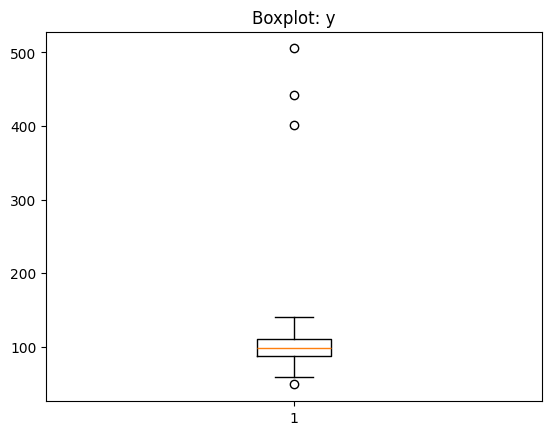

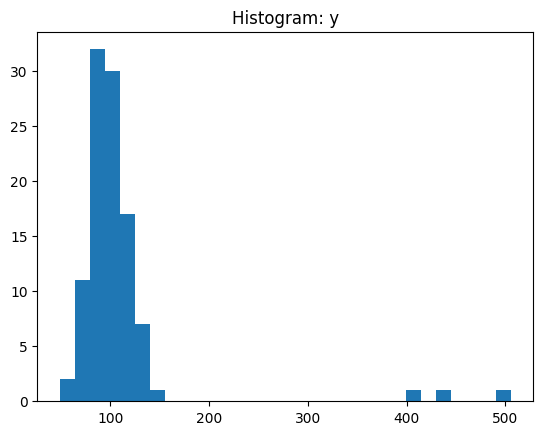

In [21]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [22]:
def summary_stats(series):
    return {
        "mean": series.mean(),
        "median": series.median(),
        "std": series.std()
    }

stats_all = summary_stats(df["x"])
stats_no_outliers = summary_stats(df.loc[~df["outlier_iqr"], "x"])
stats_winsor = summary_stats(winsorize_series(df["x"]))

pd.DataFrame(
    [stats_all, stats_no_outliers, stats_winsor],
    index=["All", "IQR-filtered", "Winsorized"]
)


,mean,median,std
All,54.040325,49.279899,30.995203
IQR-filtered,49.215666,48.843517,8.763243
Winsorized,49.588123,49.279899,8.953544


In [23]:
import statsmodels.api as sm

def fit_model(x, y):
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    return {"coef": model.params.to_dict(), "R2": model.rsquared}

results_all = fit_model(df["x"], df["y"])
results_no_out = fit_model(df.loc[~df["outlier_iqr"], "x"], df.loc[~df["outlier_iqr"], "y"])
results_win = fit_model(winsorize_series(df["x"]), winsorize_series(df["y"]))

pd.DataFrame(
    [results_all, results_no_out, results_win],
    index=["All", "IQR-filtered", "Winsorized"]
)


,coef,R2
All,"{'const': -0.42661952562150773, 'x': 2.0116960...",0.994296
IQR-filtered,"{'const': 3.712032733784195, 'x': 1.9265811502...",0.926723
Winsorized,"{'const': 5.325203922894389, 'x': 1.8987644676...",0.937787


In [24]:
# Option A: Summary stats
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

,all,filtered_iqr,winsorized
mean,108.286091,98.530007,99.481369
median,98.897971,98.734899,98.897971
std,62.531514,17.537888,17.555527


In [25]:
# Option B: Simple regression (if x present)
if 'x' in df.columns:
    X_all = df[['x']].to_numpy(); y_all = df[target_col].to_numpy()
    X_filtered = df.loc[~df['outlier_iqr'], ['x']].to_numpy(); y_filtered = df.loc[~df['outlier_iqr'], target_col].to_numpy()

    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered, y_filtered)

    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))

    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered)],
        'mae': [mae_all, mae_flt]
    }, index=['all', 'filtered_iqr'])
    results
else:
    results = None
    print("No 'x' column; skip regression or engineer features.")

### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

*Write your reflection here...*